In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # charts plotting
import plotly.graph_objects as go # more customized plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option("display.max_columns", None)

In [35]:
df_retail = pd.read_csv('/content/drive/MyDrive/Spinmaster/OnlineRetail.csv')
# print(df_retail.info())
# Initial Data Cleaning
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])
#replace null customer with 99999
df_retail[['Customer ID']] =df_retail[['CustomerID']].fillna(99999)
df_retail['CustomerID'] = pd.to_numeric(df_retail['CustomerID'], errors='coerce').fillna(-999).astype(int)
df_retail['CustomerID'] = df_retail['CustomerID'].astype(int)
#replace null description values with 'Customer_Null'
df_retail[['Description']] =df_retail[['Description']].fillna('Customer_Null')
# df_retail = df_retail[df_retail['CustomerID'].notna()]
df_retail = df_retail.sort_values(by = 'InvoiceDate')
df_retail['Total'] = df_retail['Quantity'] * df_retail['UnitPrice']

# Target Data - UK and Top 20 Items in total revenue
df_uk = df_retail.loc[df_retail["Country"]== "United Kingdom"]
df_target = df_uk.groupby(["StockCode","Description"])["Total"].agg({"sum"}).sort_values('sum',ascending=False).head(20)
df_target.rename(columns={'sum': 'Revenue'}, inplace=True)
df_target.reset_index(level=['StockCode', 'Description'],inplace=True)

# # Target Data filtering
df_target_data = df_uk[df_uk['StockCode'].isin(df_target['StockCode'])]
print(df_target_data.shape)
print(df_target_data["StockCode"].value_counts())
df_target_data.head()

(22148, 10)
StockCode
85123A    2215
85099B    2001
22423     1862
47566     1634
84879     1417
22197     1373
22469     1201
22386     1192
22086     1172
23298     1076
22178     1037
23084      904
22910      829
23284      713
DOT        710
79321      672
82484      666
22114      635
22502      472
21137      367
Name: count, dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer ID,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,17850.0,15.30
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,13047.0,54.08
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748,United Kingdom,13748.0,204.00
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,17850.0,15.30
82,536376,22114,HOT WATER BOTTLE TEA AND SYMPATHY,48,2010-12-01 09:32:00,3.45,15291,United Kingdom,15291.0,165.60


In [38]:
df_target_data.sort_values(by=["InvoiceDate"],ascending=True,inplace=True)
df_target_data.tail()

<ipython-input-38-6f966f74a8c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target_data.sort_values(by=["InvoiceDate"],ascending=True,inplace=True)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer ID,Total
541825,581579,22197,POPCORN HOLDER,24,2011-12-09 12:19:00,0.85,17581,United Kingdom,17581.0,20.40
541858,581580,79321,CHILLI LIGHTS,2,2011-12-09 12:20:00,5.75,12748,United Kingdom,12748.0,11.50
541874,581585,23084,RABBIT NIGHT LIGHT,12,2011-12-09 12:31:00,2.08,15804,United Kingdom,15804.0,24.96
541875,581585,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2011-12-09 12:31:00,1.69,15804,United Kingdom,15804.0,27.04
541871,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,15804.0,23.40


In [39]:
# Splitting the data into train, validation, and test sets based on InvoiceDate
train_size = int(len(df_target_data) * 0.7)
val_size = int(len(df_target_data) * 0.15)
test_size = len(df_target_data) - train_size - val_size

train_data = df_target_data[:train_size]
val_data = df_target_data[train_size:train_size+val_size]
test_data = df_target_data[train_size+val_size:]

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

# Example: Accessing the first few rows of each set
print("\nFirst few rows of training data:")
print(train_data.head())

print("\nFirst few rows of validation data:")
print(val_data.head())

print("\nFirst few rows of test data:")
print(test_data.head())


Train data size: 15503
Validation data size: 3322
Test data size: 3323

First few rows of training data:
   InvoiceNo StockCode                         Description  Quantity  \
0     536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
9     536367     84879       ASSORTED COLOUR BIRD ORNAMENT        32   
46    536371     22086     PAPER CHAIN KIT 50'S CHRISTMAS         80   
49    536373    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
82    536376     22114   HOT WATER BOTTLE TEA AND SYMPATHY        48   

           InvoiceDate  UnitPrice  CustomerID         Country  Customer ID  \
0  2010-12-01 08:26:00       2.55       17850  United Kingdom      17850.0   
9  2010-12-01 08:34:00       1.69       13047  United Kingdom      13047.0   
46 2010-12-01 09:00:00       2.55       13748  United Kingdom      13748.0   
49 2010-12-01 09:02:00       2.55       17850  United Kingdom      17850.0   
82 2010-12-01 09:32:00       3.45       15291  United Kingdom      15291

In [40]:
train_data.to_csv('/content/drive/MyDrive/Spinmaster/train_data.csv', index=False)
val_data.to_csv('/content/drive/MyDrive/Spinmaster/val_data.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Spinmaster/test_data.csv', index=False)

In [42]:
train_data = pd.read_csv('/content/drive/MyDrive/Spinmaster/train_data.csv')
train_data1 = train_data[~train_data['InvoiceNo'].str.contains('C', na=False)]
train_data1['InvoiceDate'] = pd.to_datetime(train_data1['InvoiceDate'])

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

train_data1 = remove_outliers_iqr(train_data1, 'UnitPrice')
train_data1.shape

<ipython-input-42-56ce4ae75bf1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['InvoiceDate'] = pd.to_datetime(train_data1['InvoiceDate'])


(13301, 10)

In [43]:
# Extract Time based features

# Weekend Flag
train_data2 = train_data1.copy()
train_data2['InvoiceDayOfWeek'] = train_data2['InvoiceDate'].dt.dayofweek
# Monday=0, Sunday=6
train_data2['IsWeekend'] = train_data2['InvoiceDayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Week of Year
train_data2['WeekOfYear'] = train_data2['InvoiceDate'].dt.isocalendar().week

# Month
train_data2['Month'] = train_data2['InvoiceDate'].dt.month
train_data2.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer ID,Total,InvoiceDayOfWeek,IsWeekend,WeekOfYear,Month
7604,553180,23298,SPOTTY BUNTING,2,2011-05-15 11:35:00,4.95,16466,United Kingdom,16466.0,9.90,6,1,19,5
4624,546751,22502,PICNIC BASKET WICKER SMALL,1,2011-03-16 12:45:00,5.95,13668,United Kingdom,13668.0,5.95,2,0,11,3
3302,543647,79321,CHILLI LIGHTS,5,2011-02-10 19:49:00,5.75,12841,United Kingdom,12841.0,28.75,3,0,6,2
3065,543127,22386,JUMBO BAG PINK POLKADOT,20,2011-02-03 14:51:00,1.95,16748,United Kingdom,16748.0,39.00,3,0,5,2
10109,557891,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2011-06-23 14:05:00,2.95,17652,United Kingdom,17652.0,17.70,3,0,25,6


In [60]:
import datetime as dt
max_date = train_data2['InvoiceDate'].max()
latest_date = dt.datetime(max_date.year, max_date.month, max_date.day)

recency = (latest_date - train_data2.groupby("Customer ID").agg({"InvoiceDate":"max"}))
# Rename column name as Recency
recency.rename(columns = {"InvoiceDate":"Recency"}, inplace = True)
# Change the values to day format
recency_df = recency["Recency"].apply(lambda x: x.days)
recency_df

,Recency
Customer ID,
12747.0,38
12748.0,-1
12749.0,59
12820.0,255
12822.0,-1
...,...
18272.0,42
18278.0,2
18280.0,206


In [64]:
# Engineered Features - RFM
train_data3 = train_data2.copy()
train_data3['ProductSaleFrequency'] = train_data3.groupby('StockCode')['Quantity'].transform('count')
# This is how many times a particular product was invoiced by different customers

# Create customer-based features
train_data3['CustomerOrderCount'] = train_data3.groupby('CustomerID')['InvoiceNo'].transform('count')
# This is how many times a customer ordered through this online store

# Customer Recency - Hpw recently did a customer make a transaction at the online store
import datetime as dt
max_date = train_data3['InvoiceDate'].max()
latest_date = dt.datetime(max_date.year, max_date.month, max_date.day)

recency = (latest_date - train_data3.groupby("Customer ID").agg({"InvoiceDate":"max"}))
recency.rename(columns = {"InvoiceDate":"Customer_Recency"}, inplace = True)
# Change the values to day format
recency_df = recency["Customer_Recency"].apply(lambda x: x.days).reset_index()
train_data3 = pd.merge(train_data3, recency_df, on='Customer ID', how='left')
train_data3.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer ID,Total,InvoiceDayOfWeek,IsWeekend,WeekOfYear,Month,ProductSaleFrequency,CustomerOrderCount,Customer_Recency
7248,554986,22469,HEART OF WICKER SMALL,4,2011-05-29 12:35:00,1.65,14451,United Kingdom,14451.0,6.60,6,1,21,5,899,4,123
10051,561258,82484,WOOD BLACK BOARD ANT WHITE FINISH,24,2011-07-26 12:03:00,6.75,15513,United Kingdom,15513.0,162.00,1,0,30,7,449,21,23
11246,564301,22197,POPCORN HOLDER,12,2011-08-24 11:54:00,0.85,14299,United Kingdom,14299.0,10.20,2,0,34,8,885,8,7
9229,559499,47566,PARTY BUNTING,59,2011-07-08 14:22:00,10.79,-999,United Kingdom,99999.0,636.61,4,0,27,7,1410,2635,-1
4602,548743,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2011-04-04 12:05:00,2.95,14895,United Kingdom,14895.0,17.70,0,0,14,4,1719,19,20


In [65]:
train_data4 = train_data3.copy()
train_data4['month_num'] = train_data4['Month'].apply(lambda x: (x - 1) % 12 + 1)

# Apply sine and cosine transformation
train_data4['month_sin'] = np.sin(2 * np.pi * train_data4['month_num'] / 12)
train_data4['month_cos'] = np.cos(2 * np.pi * train_data4['month_num'] / 12)

# Target Encoding for Each Stockcode
# Calculate the mean of 'Quantity' for each 'StockCode'

stockcode_target_encoding = train_data4.groupby('StockCode')['Quantity'].mean()

# # Merge the target encoding back into the main DataFrame
train_data4['StockCode_TargetEncoded'] = train_data4['StockCode'].map(stockcode_target_encoding)

train_data4.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Customer ID,Total,InvoiceDayOfWeek,IsWeekend,WeekOfYear,Month,ProductSaleFrequency,CustomerOrderCount,Customer_Recency,month_num,month_sin,month_cos,StockCode_TargetEncoded
10908,563377,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2011-08-16 10:44:00,1.69,15002,United Kingdom,15002.0,27.04,1,0,33,8,1018,11,44,8,-8.660254e-01,-5.000000e-01,24.307466
1610,540275,22197,SMALL POPCORN HOLDER,10,2011-01-06 12:11:00,0.85,13680,United Kingdom,13680.0,8.50,3,0,1,1,885,5,266,1,5.000000e-01,8.660254e-01,34.024859
2815,543746,85099B,JUMBO BAG RED RETROSPOT,10,2011-02-11 13:50:00,1.95,17675,United Kingdom,17675.0,19.50,4,0,6,2,1504,53,-1,2,8.660254e-01,5.000000e-01,21.789894
164,536756,22197,SMALL POPCORN HOLDER,3,2010-12-02 14:23:00,0.85,-999,United Kingdom,99999.0,2.55,3,0,48,12,885,2635,-1,12,-2.449294e-16,1.000000e+00,34.024859
13006,568491,22086,PAPER CHAIN KIT 50'S CHRISTMAS,3,2011-09-27 11:58:00,2.95,15443,United Kingdom,15443.0,8.85,1,0,39,9,427,7,2,9,-1.000000e+00,-1.836970e-16,12.845433


In [86]:
# Feature Scaling
num_feat = [ 'UnitPrice', 'ProductSaleFrequency',
             'CustomerOrderCount','Customer_Recency'
           ]
df_num = train_data4[num_feat]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_num)
df_scaled_features = pd.DataFrame(scaled_features, columns=num_feat)

other_feat = [ 'IsWeekend', "month_sin",
             "month_cos", 'StockCode_TargetEncoded']
df_other_feat = train_data4[other_feat + ['Quantity']]
df_final = pd.concat([df_scaled_features, df_other_feat], axis=1)

df_final.head(5)

,UnitPrice,ProductSaleFrequency,CustomerOrderCount,Customer_Recency,IsWeekend,month_sin,month_cos,StockCode_TargetEncoded,Quantity
0,-0.469099,1.530699,-0.496207,3.898352,0,-2.449294e-16,1.0,19.267016,6
1,-0.819787,0.051753,-0.506743,0.881404,0,-2.449294e-16,1.0,24.307466,32
2,-0.469099,-1.195119,-0.510575,-0.301118,0,-2.449294e-16,1.0,12.845433,80
3,-0.469099,1.530699,-0.496207,3.898352,0,-2.449294e-16,1.0,19.267016,6
4,-0.102101,-1.608633,-0.508659,0.987528,0,-2.449294e-16,1.0,9.558442,48


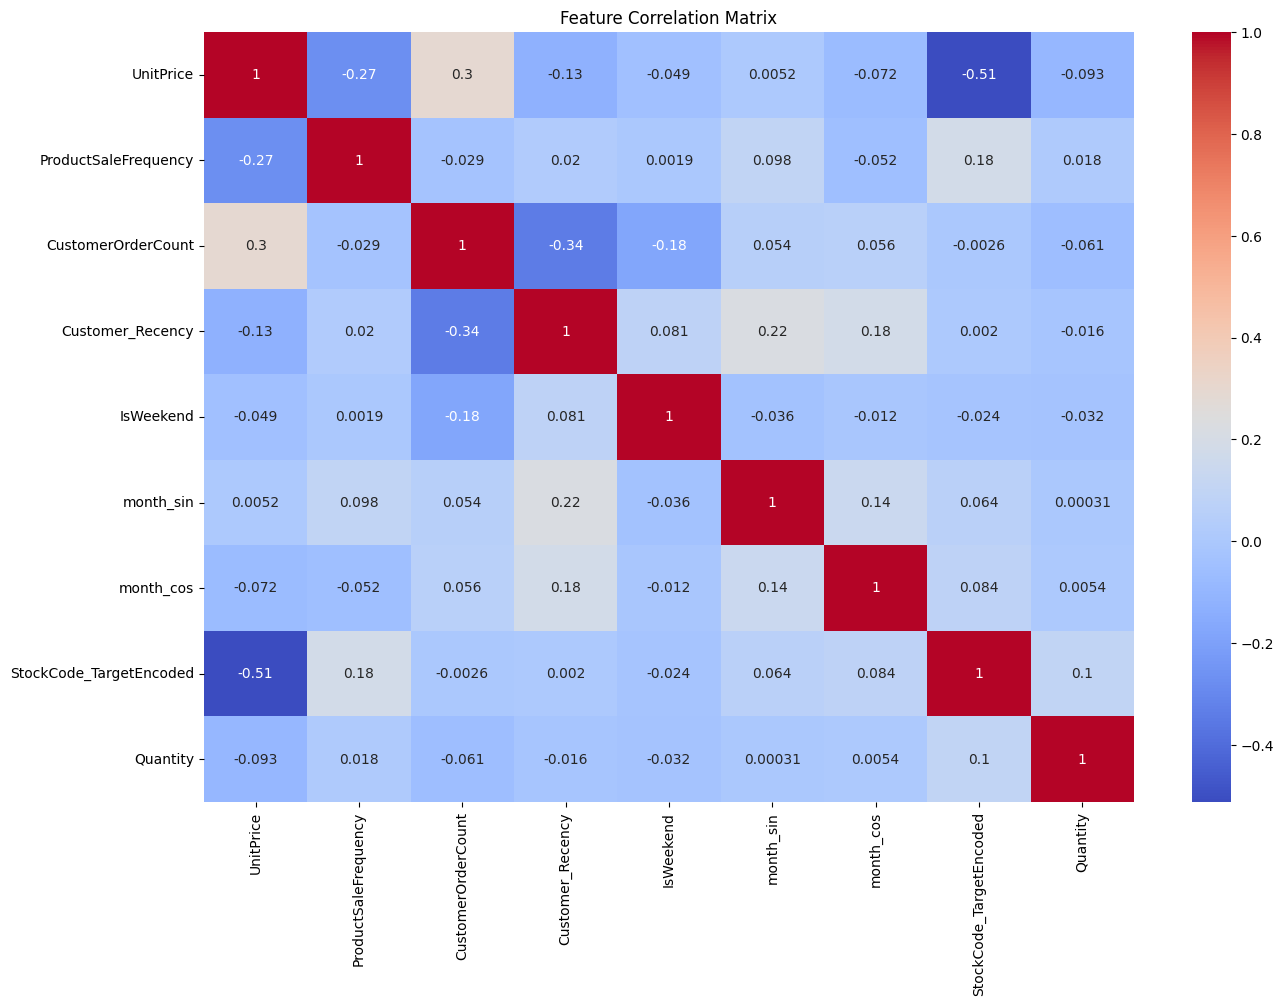

In [88]:
# Define features for analysis
feat_sel = num_feat + other_feat
# Create correlation matrix visualization
plt.figure(figsize=(15, 10))
correlation_matrix = df_final[feat_sel + ["Quantity"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [89]:
target = 'Quantity'
X_train = train_data4[feat_sel]
y_train = train_data4[target]
print(X_train.shape)
print(y_train.shape)

(13301, 8)
(13301,)


In [90]:
X_train.head(5)

,UnitPrice,ProductSaleFrequency,CustomerOrderCount,Customer_Recency,IsWeekend,month_sin,month_cos,StockCode_TargetEncoded
0,2.55,1719,17,301,0,-2.449294e-16,1.0,19.267016
1,1.69,1018,6,102,0,-2.449294e-16,1.0,24.307466
2,2.55,427,2,24,0,-2.449294e-16,1.0,12.845433
3,2.55,1719,17,301,0,-2.449294e-16,1.0,19.267016
4,3.45,231,4,109,0,-2.449294e-16,1.0,9.558442
